# The Non Random Two Liquids (NRTL) model for *excess Gibbs energy* ($g^E$) in a case study of Liquid-Liquid equilibria of Ethyl acetate (1) + water (2) + ethanol (3) --  the  scipy verified numerical methods approach

Having discussed Excess properties, the NRTL model specifically, and VLE,
Having successfully discussed LLE
A parentheses to discuss the verified scipy numerical methods approach

# Requirements

# The NumPy package
for array structures and operations

In [1]:
import numpy as np

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [42]:
from scipy.constants import R
print(R)

8.3144598


# scipy optmization package

In [4]:
from scipy import optimize as opt

# The NRTL model
as presented in previous lecture

reproduced below in minimalist numpy/numba format

In [5]:
from numba import jit
@jit
def Gamma(T,c_x,q_alpha, q_A):
    q_tau     = q_A/T
    q_G       = np.exp(-(q_alpha*q_tau))
    l_D       = ((1/((q_G.T) @ c_x)).T)
    q_E       = (q_tau*q_G) * l_D 
    gamma     = np.exp(((q_E+(q_E.T))-(((q_G * l_D) * (c_x.T)) @ (q_E.T))) @ c_x)
    return gamma

# fited parameters
 
 Renon and Prausnitz, 1969

In [6]:
# Ethyl acetate (1) + water (2) + ethanol (3)

alpha12 = 0.4

alpha23 = 0.3

alpha13 = 0.3

# 6 binary Aij parameters
Dg12 = 1335 * 4.184 #J/K
Dg21 = 2510 * 4.184 #J/K

Dg23 = 976 * 4.184 #J/K
Dg32 = 88 * 4.184 #J/K

Dg13 = 301 * 4.184 #J/K
Dg31 = 322 * 4.184 #J/K

## Feeding the fitted parameters to the model in matrix structure:
we will assemble the parameters in a matrix structure compatible with the current imlementation of the model

In [7]:
#assemble matrix with regressed parameters Dg_i,j, according to the model all diagonal terms are zero
Dg = np.array([[0, Dg12, Dg13],
             [Dg21, 0, Dg23],
             [Dg31, Dg32, 0]])


#assemble symmetric matrix alpha
alpha = np.array([[0, alpha12, alpha13],
                [alpha12, 0, alpha23],
                [alpha13, alpha23, 0]])

A= Dg/R

In [8]:
T = 273+70 #K

# Liq-Liq Equilibria Flash
already discussed

# initial guess


In [35]:
#Estimativas Iniciais

def iguess(Z,MODEL):
    #print(Z)

    gama0 = MODEL(Z/np.sum(Z))
    
    Xlin = 1/(gama0.T @ Z) * (gama0*Z)

    gamalin = MODEL(Xlin/np.sum(Xlin))

    Klin = (1./gamalin) * gama0

    KlinMin = np.min(Klin)
    KlinMax = np.max(Klin)

    NT = (KlinMax - KlinMin)
    
    nI0 = (KlinMax - Klin) * Z

    nII0 = (Klin-KlinMin) * Z
    
    beta0 = np.array([[ 1/(KlinMax-KlinMin) * np.sum(nII0) ]])
    
    ###
    
    XI0 = 1/(np.sum(nI0)) * nI0

    gamaI0=MODEL(XI0/np.sum(XI0))

    XII0 = 1/(np.sum(nII0)) * nII0

    gamaII0=MODEL(XII0/np.sum(XII0))
    
    K0 = (gamaI0)/(gamaII0)
    
    #print(XI0, XII0, gamaI0, gamaII0, K0)
    
    return beta0, K0

# algorithm


as before:
* explict

In [36]:
def ELLflash_explicit(Z,beta0,K0,MODEL,qolog):
    
    #copy intial guesses to local variables
    beta=beta0.copy()
    K=K0.copy()

    converged = 0 # flag indicating not converged yet
    
    if qolog:
        itlogi=0
        itlogv=np.ndarray(2,dtype=object)
        itlogv[0]=np.zeros(100*100)
        itlogv[1]=np.zeros([100*100,3])
    
    #initialize local arrays
    a = np.zeros(3)
    XI = np.zeros(3)
    XII = np.zeros(3)
    
    looped2=0
    looped3=0
    
    #managing loop for fixed point point algorithm
    looping2 = 0
    while ( (looping2 == 0) # means do at least once
           or ((ResK)>0.0001 # convergence criteria
               and looping2 < 100) ): # max number of iterations

        prevK = K.copy()
        
        #print(np.may_share_memory(K,prevK))
        
        #Solve RachfordRice equation with a newton raphson loop
        looping3 = 0
        while ( (looping3 == 0) # means do at least once
               or ((ResBeta)>0.0001 # convergence criteria
                   and looping3 < 100) ): #max number of iterations
            
            prevbeta = beta.copy()

            for i in range(3):
                a[i] = ( (K[i]-1) / (1+beta*(K[i]-1)) )            
                
            R=0 #residue funtion (F)
            for j in range(3):
                R+=Z[j]*a[j]

            J=0 #jacobian (Fprime)
            for j in range(3):
                J-=Z[j]*a[j]*a[j]
                            
            beta -= R/J #NR step            
            
            if beta[0,0]<0:
                beta[0,0]=0
                
            if 1<beta[0,0]:
                beta[0,0]=1
            
            ResBeta = abs(beta[0,0]-prevbeta[0,0])
            
            looping3 += 1        
            
            if qolog:
                #print(looping3,beta0,prevbeta[0,0],beta[0,0],ResBeta)
                itlogv[0][itlogi] = beta[0,0]
                itlogv[1][itlogi,0:3] = K[0:3,0]
                itlogi += 1
            
        looped3+= looping3

        for i in range(3):
            XI[i] = Z[i] * (1./(1+beta * (K[i]-1))) #Rachford-Rice composition updating scheme
                
        gamaI = MODEL(XI/np.sum(XI)) #enforce normalization in the MODEL call
        
        for i in range(3):
            XII[i] = K[i]*XI[i]

        gamaII = MODEL(XII/np.sum(XII)) #enforce normalization in the MODEL call
        
        for i in range(3):
            K[i] = (gamaI[i])/(gamaII[i]) #definition of K
        
        ResK=0
        for i in range(3):
            ResK += np.sqrt((prevK[i]-K[i])**2)
        looping2 += 1
    
    looped2 += looping2
        
    #print('Calculation has ended')
    if (looping2 < 100 and looping3 < 100 and (0.<=beta[0,0]<=1.) ):
        converged = 1
    
    if qolog:
        return XI, XII, beta, converged, looped2, looped3, itlogv
    else:
        return XI, XII, beta, converged, looping2, looped3

* linalg version

In [37]:
def ELLflash_linalg(Z,beta0,K0,MODEL): #ELLflash_linalg
    
    beta=beta0.copy()
    K=K0.copy()
    
    converged = 0
    
    looped2 = 0
    looped3 = 0
    
    looping2 = 0
    while ( (looping2 == 0) # means do at least once
           or ((ResK)>0.0001 # convergence criteria
               and looping2 < 100) ): # max number of iterations

        prevK = K.copy()        
        
        looping3 = 0
        while ( (looping3 == 0)
               or (ResBeta>0.0001 # convergence criteria
                   and looping3 < 100) ): #max number of iterations
            
            prevbeta = beta.copy()
            
            a = (1/(1+beta*(K-1))) * (K-1)
            beta = beta+(1/((Z.T*a.T) @ a)) @ (Z.T @ a)

            if beta[0,0]<0:
                beta[0,0]=0
                
            if 1<beta[0,0]:
                beta[0,0]=1
            
            ResBeta = beta[0,0]-prevbeta[0,0]

            looping3 += 1
            
        looped3 += looping3

        XI = (1./(1+beta * (K-1))) * Z

        gamaI = MODEL(XI/np.sum(XI))
        
        XII = K*XI

        gamaII = MODEL(XII/np.sum(XII))
        
        K = (gamaI)/(gamaII)
        
        ResK = np.linalg.norm(K-prevK)
        
        looping2 += 1 
        
    looped2 += looping2

    #print('Calculation has ended')
    if (looping2 < 100 and looping3 < 100  and ( 0. <= beta[0,0] <= 1.)  ):
        converged = 1
    
    return XI, XII, beta, converged, looped2, looped3

* new here: a jit version

In [38]:
@jit(nopython=True)
def ELLflash_fast(Z,beta0,K0,T,alpha,A):
    beta=beta0.copy()
    prevbeta=beta.copy()
    K=K0.copy()
    prevK=K.copy()
    XI=Z.copy()
    XII=Z.copy()
    looping2=0
    looping3=0
    converged = 0
    looped2 = 0
    looped3 = 0
    ResK=1
    ResBeta=1
    
    looping2 = 0
    while ( (looping2 == 0) # means do at least once
           or ((ResK)>0.0001 # convergence criteria
               and looping2 < 100) ): # max number of iterations

        prevK = K.copy()        
        
        looping3 = 0
        while ( (looping3 == 0)
               or (ResBeta>0.0001 # convergence criteria
                   and looping3 < 100) ): #max number of iterations
            
            prevbeta = beta.copy()
            
            a = (1/(1+beta*(K-1))) * (K-1)
            beta = beta+(1/((Z.T*a.T) @ a)) @ (Z.T @ a)

            if beta[0,0]<0:
                beta[0,0]=0
                
            if 1<beta[0,0]:
                beta[0,0]=1
            
            ResBeta = np.abs(beta[0,0]-prevbeta[0,0])

            looping3 += 1
            
        looped3 += looping3


        XI = (1./(1+beta * (K-1))) * Z

        gamaI = Gamma(T,XI/np.sum(XI),alpha,A)
        
        XII = K*XI

        gamaII = Gamma(T,XII/np.sum(XII),alpha,A)
        
        K = (gamaI)/(gamaII)
        
        ResK = np.linalg.norm(K-prevK)
        
        looping2 += 1    
    
    looped2 += looping2
    #print('Calculation has ended')
    if (looping2 < 100 and looping3 < 100  and ( 0. <= beta[0,0] <= 1.)  ):
        converged = 1
    
    return XI, XII, beta, converged, looped2, looped3

* new here: a scipy based version

In [52]:
def ELLflash_sci(Z,beta0,K0,MODEL):
    #prepare FP input
    def fix(kxixiibeta): 
        #local varaibles translation
        K=np.array([kxixiibeta[0:3]]).T
        beta0 = np.array([[kxixiibeta[9]]])
        #prepare NR input
        F = lambda beta, K=K, Z=Z: (Z.T @ ((1/(1+beta*(K-1))) * (K-1)))
        J = lambda beta, K=K, Z=Z: -(((Z.T*((1/(1+beta*(K-1))) * (K-1)).T) @ ((1/(1+beta*(K-1))) * (K-1))))
        #run NR
        beta = opt.newton(func=F,x0=beta0,fprime=J,tol=1e-4, maxiter=100)
        #run XI, gammaI, XII, gammaII
        XI = (1./(1+beta * (K-1))) * Z
        gamaI = MODEL(XI/np.sum(XI))
        XII = K*XI
        gamaII = MODEL(XII/np.sum(XII))
        #prepare return-format solution
        return np.concatenate( ( ((gamaI)/(gamaII))[0:,0], XI[0:,0], XII[0:,0], beta[0:,0] ), axis=0 )
    #prepare FP input
    point0 = np.concatenate( ( K0[0:,0], np.zeros(3), np.zeros(3), beta0[0:,0] ), axis=0 )
    #sanity check
    if np.isnan(point0).any() or np.isinf(point0).any():
        print('nans or infs here')
        raise ValueError
    #run FP    
    point = opt.fixed_point(func = fix, x0 = point0, xtol=1e-04, maxiter=100,method='iteration')
    #prepare return-format solution
    K = np.array([point[0:3]]).T
    XI = np.array([point[3:6]]).T
    XII = np.array([point[6:9]]).T
    beta = np.array([point[9:10]]).T
    converged=1
    return XI, XII, beta, converged

In [50]:
#test

#exact ad-hoc NRTL solution
#Ztest = np.array([[ 0.10526316,  0.84210526,  0.05263158]]).T
#XItest = np.array([[ 0.02616646,  0.93009914,  0.0437344 ]]).T
#XIItest = np.array([[ 0.51520944,  0.38604626,  0.0987443 ]]).T
#BETAtest = np.array([[ 0.16173772]])

#appproximate
Ztest = np.array([[ 0.1,  0.85,  0.05]]).T
XItest = np.array([[ 0.025,  0.93,  0.045 ]]).T
XIItest = np.array([[ 0.5,  0.39,  0.11 ]]).T
BETAtest = np.array([[ 0.16]])


Ktest=1/(XItest/XIItest)

#beta0=BETAtest
#k0=Ktest
Z=Ztest

MODEL = lambda x: Gamma(T,x,alpha,A)

beta0, k0 = iguess(Z,MODEL)

In [54]:
ans=ELLflash_explicit(Z,beta0,k0,MODEL,False)

print('at T', T, 'Z', Z.T)
print('with ig of k0', k0.T,'beta0', beta0)
print('solution is')
print('xi',ans[0].T)
print('xii',ans[1].T)
print('beta',ans[2])
print('converged?',ans[3], '-- 1 means yes')

ans=ELLflash_linalg(Z,beta0,k0,MODEL)

print('at T', T, 'Z', Z.T)
print('with ig of k0', k0.T,'beta0', beta0)
print('solution is')
print('xi',ans[0].T)
print('xii',ans[1].T)
print('beta',ans[2])
print('converged?',ans[3], '-- 1 means yes')

ans=ELLflash_fast(Z,beta0,k0,T,alpha,A)

print('at T', T, 'Z', Z.T)
print('with ig of k0', k0.T,'beta0', beta0)
print('solution is')
print('xi',ans[0].T)
print('xii',ans[1].T)
print('beta',ans[2])
print('converged?',ans[3], '-- 1 means yes')

ans=ELLflash_sci(Z,beta0,k0,MODEL)

print('at T', T, 'Z', Z.T)
print('with ig of k0', k0.T,'beta0', beta0)
print('solution is')
print('xi',ans[0].T)
print('xii',ans[1].T)
print('beta',ans[2])
print('converged?',ans[3], '-- 1 means yes')

at T 343 Z [[ 0.1   0.85  0.05]]
with ig of k0 [[ 53.51704507   0.08210211   1.89504205]] beta0 [[ 0.10903288]]
solution is
xi [ 0.02558676  0.93241488  0.04199836]
xii [ 0.52333357  0.38114549  0.09552094]
beta [[ 0.14950019]]
converged? 1 -- 1 means yes
at T 343 Z [[ 0.1   0.85  0.05]]
with ig of k0 [[ 53.51704507   0.08210211   1.89504205]] beta0 [[ 0.10903288]]
solution is
xi [[ 0.02558676  0.93241488  0.04199837]]
xii [[ 0.52333358  0.38114547  0.09552094]]
beta [[ 0.14950018]]
converged? 1 -- 1 means yes
at T 343 Z [[ 0.1   0.85  0.05]]
with ig of k0 [[ 53.51704507   0.08210211   1.89504205]] beta0 [[ 0.10903288]]
solution is
xi [[ 0.02558676  0.93241488  0.04199836]]
xii [[ 0.52333357  0.38114549  0.09552094]]
beta [[ 0.14950019]]
converged? 1 -- 1 means yes
at T 343 Z [[ 0.1   0.85  0.05]]
with ig of k0 [[ 53.51704507   0.08210211   1.89504205]] beta0 [[ 0.10903288]]
solution is
xi [[ 0.02558847  0.93240983  0.0420017 ]]
xii [[ 0.52354738  0.38092664  0.09552599]]
beta [[ 0.149

In [55]:
#all , with objective initial guess

# explicit
%timeit ELLflash_explicit(Z,beta0,k0,MODEL,False)
ans=ELLflash_explicit(Z,beta0,k0,MODEL,False)
print(ans[3],ans[2])

# linalg
%timeit ELLflash_linalg(Z,beta0,k0,MODEL)
ans=ELLflash_linalg(Z,beta0,k0,MODEL)
print(ans[3],ans[2])

# fast
%timeit ELLflash_fast(Z,beta0,k0,T,alpha,A)
ans=ELLflash_fast(Z,beta0,k0,T,alpha,A)
print(ans[3],ans[2])


# sci
%timeit ELLflash_sci(Z,beta0,k0,MODEL)
ans=ELLflash_sci(Z,beta0,k0,MODEL)
print(ans[3],ans[2])

#my results:
'''
The slowest run took 12.71 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 1.37 ms per loop
6 [[ 0.22367347]]
1000 loops, best of 3: 769 µs per loop
6 [[ 0.22367347]]
10000 loops, best of 3: 61 µs per loop
6 [[ 0.22367347]]
100 loops, best of 3: 2.36 ms per loop
1 [[ 0.22367347]]
'''

'''
The slowest run took 4.01 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 1.4 ms per loop
6 [[ 0.22367347]]
1000 loops, best of 3: 770 µs per loop
6 [[ 0.22367347]]
10000 loops, best of 3: 60.7 µs per loop
6 [[ 0.22367347]]
100 loops, best of 3: 2.36 ms per loop
1 [[ 0.22367347]]
'''
# a 2x speedup using linalg, another 10x speedup using numba/jit, a 30% slowdown using scipy

'''10 loops, best of 3: 18.9 ms per loop
1 [[ 0.19194152]]
100 loops, best of 3: 9.65 ms per loop
1 [[ 0.19194152]]
1000 loops, best of 3: 649 µs per loop
1 [[ 0.19194152]]
100 loops, best of 3: 8.24 ms per loop
1 [[ 0.19194782]]
 
'''

'''10 loops, best of 3: 20.6 ms per loop
1 [[ 0.14950019]]
100 loops, best of 3: 12.1 ms per loop
1 [[ 0.14950018]]
1000 loops, best of 3: 751 µs per loop
1 [[ 0.14950019]]
100 loops, best of 3: 19.4 ms per loop
1 [[ 0.14943308]]
 '''

print(' ')

10 loops, best of 3: 20.6 ms per loop
1 [[ 0.14950019]]
100 loops, best of 3: 12.1 ms per loop
1 [[ 0.14950018]]
1000 loops, best of 3: 751 µs per loop
1 [[ 0.14950019]]
100 loops, best of 3: 19.4 ms per loop
1 [[ 0.14943308]]
 


# grid calc plot

In [56]:
nspace = 20

Z2 = np.linspace(0,1,nspace)
Z3 = np.linspace(0,1,nspace)

Z2[0]=1e-9
Z3[0]=1e-9


Z2[-1]=1-1e-9
Z3[-1]=1-1e-9


rawZs = np.ndarray((nspace,nspace), dtype=object)

flags = np.zeros((nspace,nspace))

for i in range(nspace):
    for j in range(nspace):
        rawZs[i,j]=np.array([1-Z2[i]-Z3[j],Z2[i],Z3[j]])
        if ( Z2[i] + Z3[j] <= 1 ):
            flags[i,j] = 1
        

            
Zs = rawZs[np.where(flags==1)]

npts = Zs.shape[0]
print(npts)

Resultados_beta = np.zeros([npts])
Resultados_conv = np.zeros([npts])
Resultados_Z = np.zeros([npts,3])
Resultados_XI = np.zeros([npts,3])
Resultados_XII = np.zeros([npts,3])

MODEL = lambda x: Gamma(T,x,alpha,A)

l=0
for k in range(npts):
    beta0, K0 = iguess(np.array([Zs[k]]).T,MODEL)
    #print(beta0,K0)
    #print(Zs[k],beta0,K0)
    try:
        ans = ELLflash_sci(np.array([Zs[k]]).T,beta0,K0,MODEL)

        #succeeds:

        if (0<ans[2] and 1>ans[2] and ans[3]!=0):
            #print(ans[0][0][0],ans[0][1][0],ans[0][2][0])
            #print(ans[0][0:3,0])
            Resultados_XI[l,:] = ans[0][0:3,0]#np.array([ans[0][0][0],ans[0][1][0],ans[0][2][0]])
            Resultados_XII[l,:] = ans[1][0:3,0] #np.array([ans[1][0][0],ans[1][1][0],ans[1][2][0]])
            Resultados_beta[l] = ans[2]
            Resultados_conv[l] = ans[3]

            Resultados_Z[l,:] = Zs[k]
            
            #print('l++')
            l+=1

    except RuntimeError:
        #print('no converge here')
        pass
    except ValueError:
        #print('no converge here')
        pass
    finally:
        #print('k++')
        pass
    
        
print('done',l)
ndone=l
    






210
done 34


* of a grid with 210 points we foundo solutions for 28 points
* lets soon see wether we tried calculations at conditions that do not have solution, or at conds that had solutions but our algorithms missed

# note we have 34 convergences here with scipy, before we had 33 convergences,

# we can tweak scipy options and use better methods provided by scipy

In [63]:
fResultados_XI = Resultados_XI[:][np.where(Resultados_conv!=0)]
fResultados_XII = Resultados_XII[:][np.where(Resultados_conv!=0)]
fResultados_beta = Resultados_beta[np.where(Resultados_conv!=0)]
fResultados_Z = Resultados_Z[:][np.where(Resultados_conv!=0)]

In [64]:
# barycentric coords: (a,b,c)
a=fResultados_XI[:,0]
b=fResultados_XI[:,1]
c=fResultados_XI[:,2]

d=fResultados_XII[:,0]
e=fResultados_XII[:,1]
f=fResultados_XII[:,2]

g=fResultados_Z[:,0]
h=fResultados_Z[:,1]
ii=fResultados_Z[:,2]



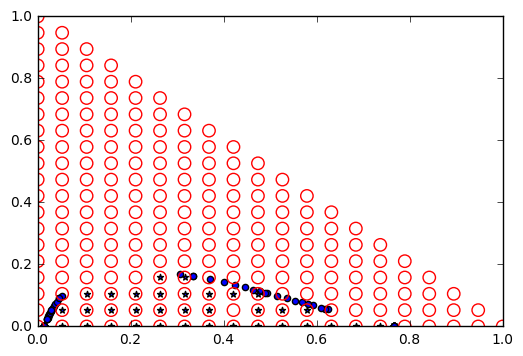

In [69]:
plt.axis([0,1,0,1])
    
plt.scatter(a,c)    
plt.scatter(d,f)    

ZS=np.zeros([npts,3])
for i in range(npts):
    ZS[i,:]=Zs[i]

plt.scatter(ZS[:,0],ZS[:,2],marker='o',s=80, facecolors='none', edgecolors='r')    
    
plt.scatter(g,ii,marker='*')

#UNCOMMENT THIS LINE TO PLOT THE FAILED POINT
#failedpoint= [0.42105263 , 0.52631579 , 0.05263158]
#plt.scatter(bug[0],bug[2],marker='d')

plt.show()

# scipy missed the same points with solution than before
# note however in the plots below tha scipy' algorithm was able to converge 1 calculation closer to the critical point than before!

In [66]:
# x crit = 0.2 aprox


#refiltrar a e b LEFT and RIGHT of the crit point

crit=.2

al=a[np.where(a<=crit)]
ar=a[np.where(a>crit)]
dl=d[np.where(d<=crit)]
dr=d[np.where(d>crit)]

bl=b[np.where(a<=crit)]
br=b[np.where(a>crit)]
el=e[np.where(d<=crit)]
er=e[np.where(d>crit)]

cl=c[np.where(a<=crit)]
cr=c[np.where(a>crit)]
fl=f[np.where(d<=crit)]
fr=f[np.where(d>crit)]

In [67]:
Ly = np.concatenate((al,dl),axis=0)
Lx = np.concatenate((cl,fl),axis=0)

Ry = np.concatenate((ar,dr),axis=0)
Rx = np.concatenate((cr,fr),axis=0)

sLy=np.sort(Ly)
sLx=np.sort(Lx)
sRy=np.sort(Ry)
sRx=-np.sort(-Rx)

print(a.shape,b.shape,d.shape,e.shape)
print(al.shape,bl.shape,dl.shape,el.shape)
print(ar.shape,br.shape,dr.shape,er.shape)
print(Ly.shape,Ry.shape,Lx.shape,Rx.shape)


(34,) (34,) (34,) (34,)
(23,) (23,) (11,) (11,)
(11,) (11,) (23,) (23,)
(34,) (34,) (34,) (34,)


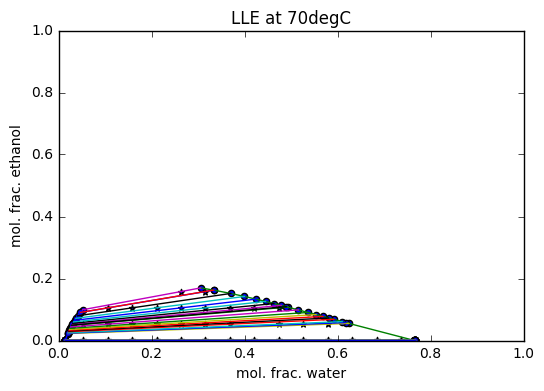

In [68]:
plt.axis([0,1,0,1])
    
plt.scatter(Ly,Lx)    
plt.scatter(Ry,Rx)    

plt.plot(sLy,sLx)
plt.plot(sRy,sRx)


for i in range(0,ndone):
    plt.plot([a[i],d[i]],[c[i],f[i]])


plt.scatter(g,ii, marker='*')

plt.xlabel('mol. frac. water')
plt.ylabel('mol. frac. ethanol')
plt.title('LLE at '+str(T-273)+'degC')    
    
plt.show()
